In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import time

In [43]:
wine_data = load_wine()
wine_features = wine_data.data
wine_feature_names = wine_data.feature_names
wine_target = wine_data.target
wine_target_names = wine_data.target_names
wine_target_names


# Create a DataFrame for better visualization
wine_df = pd.DataFrame(wine_features, columns=wine_feature_names)
wine_df['Target'] = wine_target


wine_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


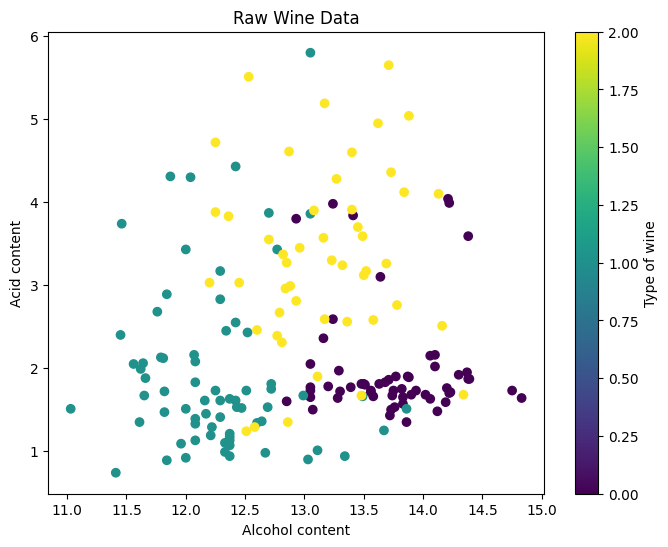

In [44]:
# Plotting the raw data - first two features for simplicity
plt.figure(figsize=(8, 6))
plt.scatter(wine_features[:, 0], wine_features[:, 1], c=wine_target)
plt.title("Raw Wine Data")
plt.xlabel("Alcohol content")
plt.ylabel("Acid content")
plt.colorbar(label='Type of wine')
plt.show()

In [45]:
# splitting the data into sets
wine_features_train, wine_features_test, wine_target_train, wine_target_test = train_test_split(
    wine_features, wine_target, test_size=0.2, random_state=42)

In [46]:
# Applying MinMaxScaler for normalization (suitable for features with varying scales)
scaler = MinMaxScaler()
wine_features_train_scaled = scaler.fit_transform(wine_features_train)
wine_features_test_scaled = scaler.transform(wine_features_test)

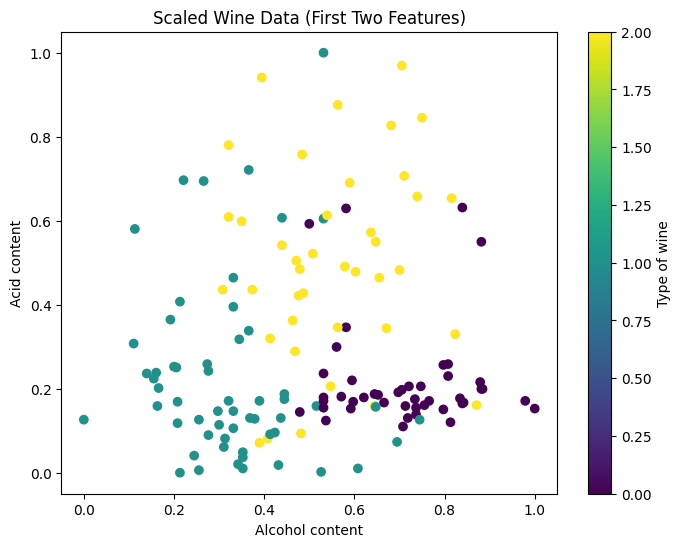

In [47]:
# Plotting the scaled data
plt.figure(figsize=(8, 6))
plt.scatter(wine_features_train_scaled[:, 0], wine_features_train_scaled[:, 1], c=wine_target_train)
plt.title("Scaled Wine Data (First Two Features)")
plt.xlabel("Alcohol content")
plt.ylabel("Acid content")
plt.colorbar(label='Type of wine')
plt.show()

In [48]:
# Define the models and their hyperparameters for grid search
models_params = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'parameters': {
            'classifier__C': [0.1, 1, 10, 100]
        }
    },
    'SVM': {
        'model': SVC(),
        'parameters': {
            'classifier__C': [0.1, 1, 10, 100],
            'classifier__gamma': [0.001, 0.01, 0.1, 1]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'parameters': {
            'classifier__n_estimators': [10, 50, 100, 200]
        }
    }
}

In [49]:
# Setting up Stratified K-Fold for better cross-validation (preserves the percentage of samples for each class)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [50]:
# Loop through each model, create a pipeline, perform grid search, fit, predict and calculate accuracy
results = {
    'Model': [],
    'Accuracy': [],
    'Time taken': []
}

for model_name, mp in models_params.items():
    # Create a pipeline with scaling and classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('classifier', mp['model'])
    ])

    # GridSearch with Stratified K-Fold
    classifier_grid_search = GridSearchCV(pipeline, mp['parameters'], cv=stratified_kfold)
    
    start_time = time.time()
    classifier_grid_search.fit(wine_features_train_scaled, wine_target_train)
    end_time = time.time()

    wine_predictions = classifier_grid_search.predict(wine_features_test_scaled)

    accuracy = accuracy_score(wine_target_test, wine_predictions)
    time_taken = end_time - start_time

    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Time taken'].append(time_taken)

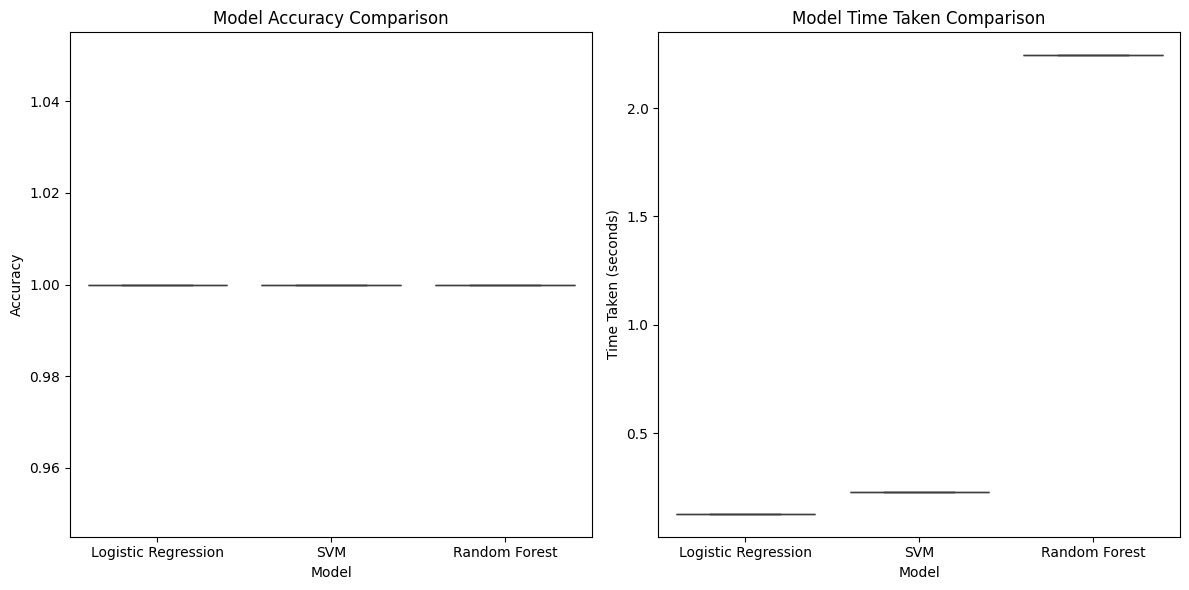

,Model,Accuracy,Time taken
0,Logistic Regression,1.0,0.128683
1,SVM,1.0,0.231357
2,Random Forest,1.0,2.243418


In [51]:
# Converting results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Plotting boxplots for accuracies and time taken
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Model', y='Accuracy', data=results_df)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")

plt.subplot(1, 2, 2)
sns.boxplot(x='Model', y='Time taken', data=results_df)
plt.title("Model Time Taken Comparison")
plt.ylabel("Time Taken (seconds)")
plt.xlabel("Model")

plt.tight_layout()
plt.show()

results_df